In [1]:
from env import GridEnvDeform, create_maze
from dqn import DQNAgent
from logger import Logger
from belief import belief_entropy

import torch
from tqdm import tqdm
from tqdm.auto import trange
import os
import argparse
import itertools
import numpy as np
import time

# maze size
N = 2

# thetas deformations (range(a,b),range(c,d))
l0 = 1
h0 = 3
l1 = 1
h1 = 2

# belief update iterations
iters = 25


# MODEL

MOVE_UP = 0
MOVE_RIGHT = 1
MOVE_DOWN = 2
MOVE_LEFT = 3

In [2]:
class POMDPWrapper_v0():
    """This is a wrapper for the GridEnvDeform class that makes the environment partially observable."""

    def __init__(self, env: GridEnvDeform, agent : DQNAgent, T,O,R,*args, **kwargs):

        self.env = env
        self.agent = agent
        self.states = [((x,y,phi),(i,j)) for x in range(1,env.max_shape[0]-1) for y in range(1,env.max_shape[1]-1) for phi in range(4) for i in range(l0,h0) for j in range(l1,h1)] 
        self.actions = [0,1,2,3]
        self.observations = list(itertools.product([0,1], repeat=5))
        self.thetas = env.deformations

        self.obs_dict = {obs : i for i, obs in enumerate(self.observations)}

        # Transition, Observation and Reward model T(S,A,S'), O(S,A,O), R(S,A,S')
        self.T = T
        self.O = O
        self.R = R

    def reset(self):
        return self.env.reset()

    def step(self, action, execute=False):

        """Returns the next observation, reward, done, info. while
        the base environment returns the next state, reward, done, info.
        """
        
        state = self.env.get_state() 
        obs = self.env.get_observation(state) 

        next_state, reward, terminated, truncated, info = self.env.step(action, execute=execute)
        next_obs = self.env.get_observation(next_state)
        
        done = True if terminated else False
        info = {"actual_state": next_state}

        # return state, action, reward, next_state, done
        # dovrei ritornare next_obs se c'è ancora obs TODO
        return next_obs, reward, done, info 
    
    def run(self, num_trajectories):
        """ 
        The idea is to run the environment to populate the replay buffer with some data
        transition for the POMDP should be like (belief, action, reward, next_belief, done)
        
        repeat
        
        Initialize belief if new episode
        for all actions compute b,a,b',r and store in replay buffer
        execute the best action in the environment
        get new belief 
        
        until populated replay buffer
        
        """


        # create a list of trajectories
        trajectories = []

        # Reset env and initialize belief 
        # Initialize belief (uniform distribution for now, probably need to change this)
        # if self.env.is_done() or self.env.is_new():
        self.env.reset()
        b = (torch.ones(len(self.states)) / len(self.states))

        while len(trajectories) < num_trajectories:
            for a in self.env.actions:
                next_obs, reward, done, _ = self.step(a)
                b_prime = self.update_belief(b, a, next_obs)

                # format state as dqn agent expects
                # state['obs'] = b (percieved state)
                # state['raw_legal_actions'] = actions
                # state['legal_actions'] = actions
                la =  {i:i for i in range(4)}
                state = {'obs':b, 'raw_legal_actions':la, 'legal_actions':la}
                next_state = {'obs':b_prime, 'raw_legal_actions':la, 'legal_actions':la}

                # Store trajectory
                # trajectories.append(({'obs':b}, a, reward, {'obs':b_prime}, done))
                trajectories.append((state, a, reward, next_state, done))

            # step in the environment
            next_obs, reward, done, _ = self.step(self.agent.step(state), execute=True)
            b = self.update_belief(b, a, next_obs)

        
        return trajectories

    def update_belief(self, belief, action, observation):
        """
        Perform a Bayesian belief update in a POMDP with action-dependent transition and observation models.

        Parameters:
            belief (torch.Tensor): Initial belief distribution over states, shape (num_states,)
            T (torch.Tensor): Transition probabilities, shape (num_states, num_actions, num_states)
            O (torch.Tensor): Observation probabilities, shape (num_states, num_actions, num_observations)
            action (int): The action taken (index of action)
            observation (int): The observation received (index of observation)

        Returns:
            torch.Tensor: The updated belief over states, shape (num_states,)
        """
        # Prediction Step: Compute predicted belief over next states
        predicted_belief = torch.matmul(belief, self.T[:, action])

        # Update Step: Multiply by observation likelihood
        observation_likelihood = self.O[:, action, self.obs_dict[tuple(observation.tolist())]]
        new_belief = predicted_belief * observation_likelihood

        # Normalize the updated belief to ensure it's a valid probability distribution
        if new_belief.sum() > 0:
            new_belief /= new_belief.sum() 
             
        return new_belief
    

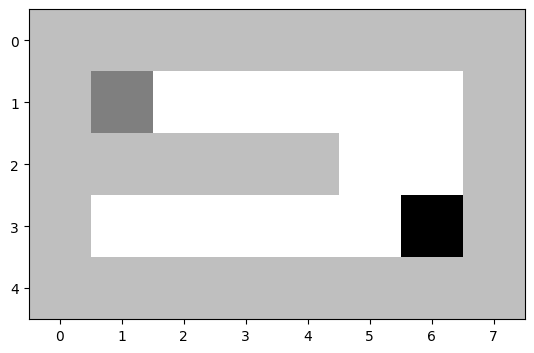

In [3]:
maze = create_maze(N)
env = GridEnvDeform(maze,l0,h0,l1,h1)
env.render()

In [13]:
# s = [(x, y, phi), thetas]
states = [((x,y,phi),(i,j)) for x in range(1,env.max_shape[0]-1) for y in range(1,env.max_shape[1]-1) for phi in range(4) for i in range(l0,h0) for j in range(l1,h1)] 
actions = [0,1,2,3]
obs = list(itertools.product([0,1], repeat=5))
thetas = [(i,j) for i in range(l0,h0) for j in range(l1,h1)]

state_dict = {state: i for i, state in enumerate(states)}
obs_dict = {obs : i for i, obs in enumerate(obs)}

# Actions are: 0-listen, 1-open-left, 2-open-right
lenS = len(states)
lenA = len(actions)
lenO = len(obs)

print(f"States: {lenS}, Actions: {lenA}, Observations {lenO}, Thetas {thetas}\n")


print("setting reward function\n")
R = torch.zeros(lenS,lenA,lenS)
for s in range(lenS):
    for a in range(lenA):
        r = env.R(states[s],a)
        for s_ in range(lenS):
            R[s][a][s_] = r

print("setting transition function\n")
T = torch.zeros(lenS,lenA,lenS)
for s, state in enumerate(states):
    for a, action in enumerate(actions):
        for s_, state_ in enumerate(states):
            T[s,a,s_] = env.T(state,action,state_)

print("setting observation function\n")
O = torch.zeros(lenS,lenA,lenO)
for s, state in enumerate(states):
    for o, observation in enumerate(obs):
        prob = env.O(state,action,observation)
        for a, action in enumerate(actions):
            O[s,a,o] = prob 



print("transition probability shape: ", T.shape)
print("reward shape: ", R.shape)
print("observation shape: ", O.shape)


States: 144, Actions: 4, Observations 32, Thetas [(1, 1), (2, 1)]

setting reward function

setting transition function

setting observation function

transition probability shape:  torch.Size([144, 4, 144])
reward shape:  torch.Size([144, 4, 144])
observation shape:  torch.Size([144, 4, 32])


In [14]:
def parse():
    parser = argparse.ArgumentParser("DQN for POMDPs Parser")

    parser.add_argument(
        '--cuda',
        type=str,
        default='cpu',
    )
    parser.add_argument(
        '--seed',
        type=int,
        default=42,
    )
    parser.add_argument(
        '--num_episodes',
        type=int,
        default=100,
    )
    parser.add_argument(
        '--num_eval_games',
        type=int,
        default=500,
    )
    parser.add_argument(
        '--evaluate_every',
        type=int,
        default=5000,
    )
    parser.add_argument(
        '--log_dir',
        type=str,
        default='logs/',
    )

    parser.add_argument(
        "--load_checkpoint_path",
        type=str,
        default="models/",
    )

    parser.add_argument(
        "--save_every",
        type=int,
        default=25000
    )

    parser.add_argument(
        "--f",
        type=str,
        default="",
    )
    args = parser.parse_args()

    os.environ["CUDA_VISIBLE_DEVICES"] = args.cuda

    # create directory if not exists
    if not os.path.exists(args.log_dir):
        os.makedirs(args.log_dir)

    args.load_checkpoint_path = args.log_dir

    return args

args = parse()

In [27]:

info = [f'num_episodes: {args.num_episodes}',
        f'evaluate_every: {args.evaluate_every}',
        f'num_eval_games: {args.num_eval_games}',
        f'save_every (checkpoints): {args.save_every}',
        f'log_dir: {args.log_dir}',
        f'load_checkpoint_path: {args.load_checkpoint_path}',
        f'seed: {args.seed}'
    ]

with Logger(args.log_dir) as logger:
        logger.log_info(info)
        

# Check whether gpu is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE :", device)  


# Initialize the agent and use random agents as opponents
agent = DQNAgent(
    num_actions=4,
    state_shape=(len(states),),
    mlp_layers=[64,64],
    device=device,
    save_path=args.log_dir,
    save_every=args.save_every,
    replay_memory_size=500,
    batch_size=64,
)

env_wrapper = POMDPWrapper_v0(env, agent, T, O, R)
   
if args.load_checkpoint_path != "":
        dirs = os.listdir(args.load_checkpoint_path)
        
        dirs = [d for d in dirs if d.startswith("checkpoint")]
        if dirs != []:
            
            dirs = sorted(dirs, key=lambda x: int(x.split("-")[1].split(".")[0]))
            path = args.load_checkpoint_path + "/" + dirs[-1] if len(dirs) > 0 else None
        
            agent = agent.from_checkpoint(checkpoint=torch.load(path))
            agent.save_every = args.save_every
            agent.save_path = args.log_dir


start_episode = agent.train_t
# Start training
with Logger(args.log_dir) as logger:
    for episode in trange(args.num_episodes):
        if episode < start_episode:
            continue

        # Generate data from the environment
        # payoffs: tuple (list of game payoffs, [player0's round_payoff, player1's round_payoff])
        trajectories = env_wrapper.run(50)

        # Reorganaize the data to be ts = state, action, reward, next_state, done
        # Feed transitions into agent memory, and train the agent
        for ts in trajectories:
            agent.feed(ts)


        # Evaluate the performance. Play with random agents.
        if episode % args.evaluate_every == 0:                
            pass


# Save model
save_path = os.path.join(args.log_dir, 'model.pth')
torch.save(agent, save_path)
print('Model saved in', save_path)


----------------------------------------
num_episodes: 100
evaluate_every: 5000
num_eval_games: 500
save_every (checkpoints): 25000
log_dir: logs/
load_checkpoint_path: logs/
seed: 42
----------------------------------------

Logs saved in logs/
DEVICE : cpu


  0%|          | 0/100 [00:00<?, ?it/s]

INFO - Step 100, rl-loss: 3.9502434730529785
INFO - Copied model parameters to target network.
INFO - Step 5200, rl-loss: 1.3603516817092896
Logs saved in logs/
Model saved in logs/model.pth


Initial state:  ((2, 3, 0), (1, 1))


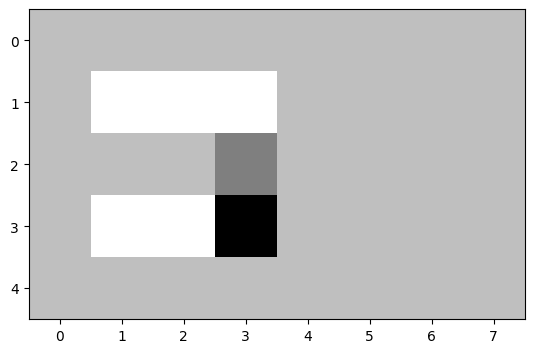

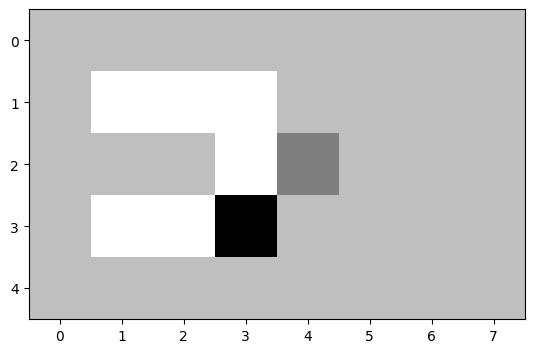

Step:  9
Timestep missing: 9  
Total reward:     -2.5  
Best action:  1
argmax and max Belief:  ((1, 1, 0), (1, 1)) tensor(0.0069)


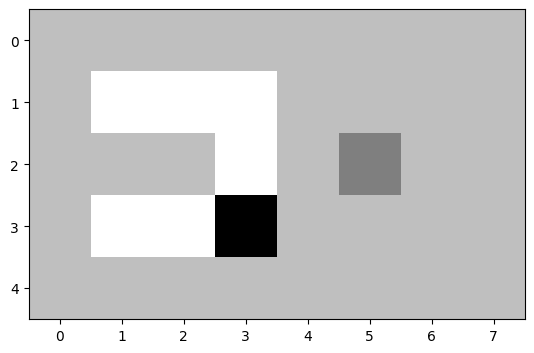

Step:  8
Timestep missing: 8  
Total reward:     -5.0  
Best action:  0
argmax and max Belief:  ((1, 1, 3), (1, 1)) tensor(0.0571)


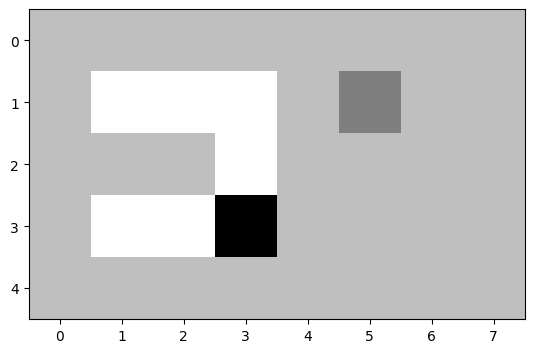

Step:  7
Timestep missing: 7  
Total reward:     -7.5  
Best action:  3
argmax and max Belief:  ((1, 5, 0), (1, 1)) tensor(0.0938)


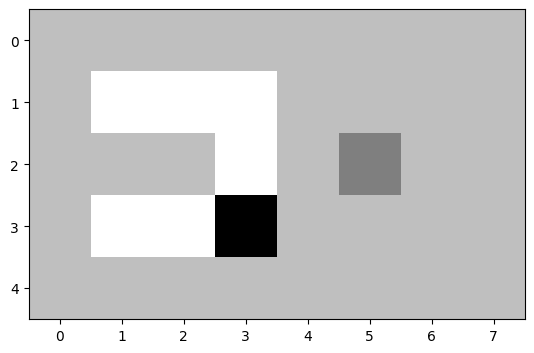

Step:  6
Timestep missing: 6  
Total reward:     -10.0  
Best action:  2
argmax and max Belief:  ((1, 6, 0), (1, 1)) tensor(0.2857)


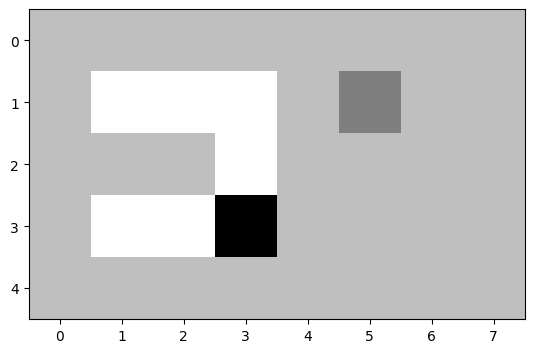

Step:  5
Timestep missing: 5  
Total reward:     -12.5  
Best action:  2
argmax and max Belief:  ((2, 6, 2), (1, 1)) tensor(0.2857)


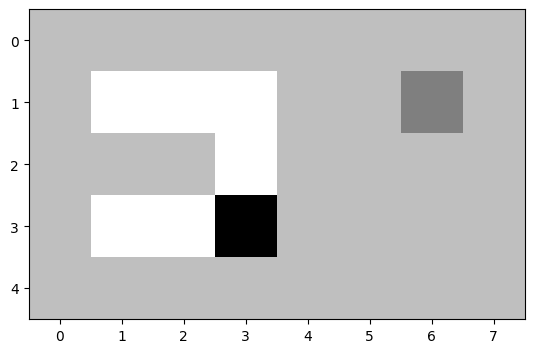

Step:  4
Timestep missing: 4  
Total reward:     -15.0  
Best action:  1
argmax and max Belief:  ((1, 6, 0), (1, 1)) tensor(0.2857)


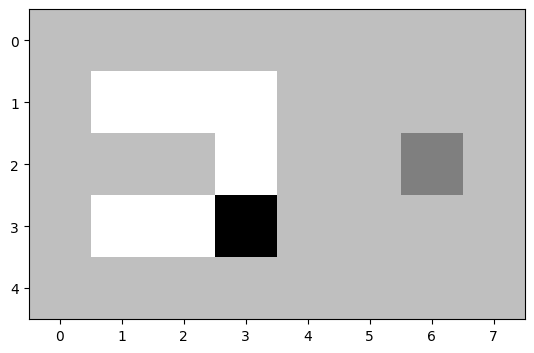

Step:  3
Timestep missing: 3  
Total reward:     -17.5  
Best action:  1
argmax and max Belief:  ((1, 6, 1), (1, 1)) tensor(0.3810)


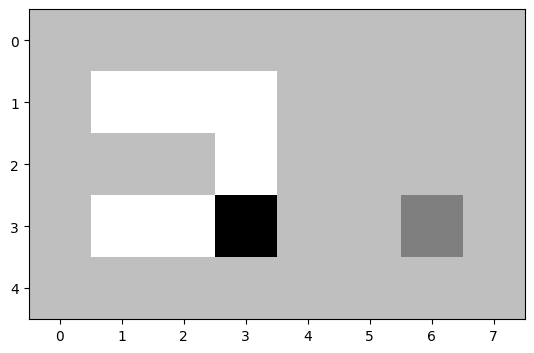

Step:  2
Timestep missing: 2  
Total reward:     -20.0  
Best action:  0
argmax and max Belief:  ((2, 6, 2), (1, 1)) tensor(0.3810)


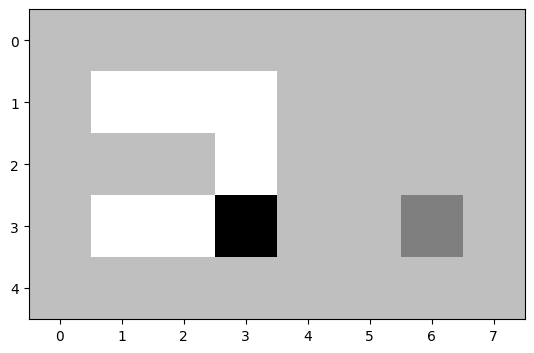

Step:  1
Timestep missing: 1  
Total reward:     -22.5  
Best action:  3
argmax and max Belief:  ((3, 6, 2), (1, 1)) tensor(0.8000)


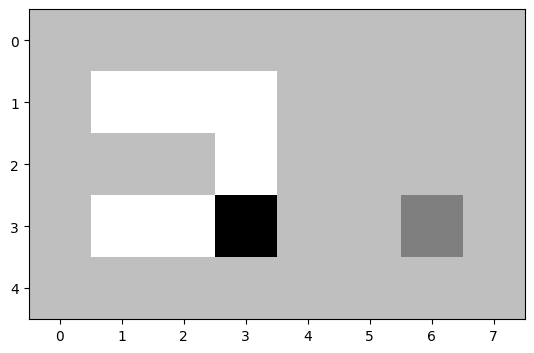

Step:  0
Timestep missing: 0  
Total reward:     -25.0  
Best action:  1
argmax and max Belief:  ((3, 6, 1), (1, 1)) tensor(0.8000)


In [29]:
# the simulation starts with given belief and random state
b = torch.ones(len(states)) / len(states)
s = np.random.randint(len(states))
la =  {i:i for i in range(4)}

print("Initial state: ", states[s])
env.render(states[s])

horizon = 10
# We loop for each step we have yet to do.
totalReward = 0.0
for t in range(horizon - 1, -1, -1):
    # We advance the world one step (the agent only sees the observation
    # and reward).
    best_action = agent.eval_step({'obs':b, 'raw_legal_actions':la, 'legal_actions':la})[0]
    #best_action = np.random.choice([0,1,2,3])
    next_obs, reward, done, info = env_wrapper.step(best_action, execute=True)
    next_state = info['actual_state']
    totalReward += reward
    env.render()


    next_belief = env_wrapper.update_belief(b, best_action, next_obs)
    
    print("Step: ", t)
    print("Timestep missing: " + str(t) + "  ") # Print space after to clear
    print("Total reward:     " + str(totalReward) + "  ")
    print("Chosen action: ", best_action)
    print("Actual State: ", next_state)
    print("argmax and max Belief: ", states[torch.argmax(b)], torch.max(b))
    print("Belief entropy: ", belief_entropy(b))

    # Then we update the world
    s = next_state
    b = next_belief
    # Sleep 1 second so the user can see what is happening.
    time.sleep(1)


In [11]:
def entropy(probabilities):
    
    # Calculate entropy, avoiding log(0) by adding a mask
    entropy = -torch.sum(probabilities * torch.log2(probabilities + (probabilities == 0).float()))
    
    return entropy.item()  # .item() to get a standard Python float

# Example tensor of probabilities
probabilities = [0.2, 0.3, 0.5]
H = entropy(b)
print("Entropy:", H)


Entropy: 6.141250133514404


# Belief update testing

In [6]:
belief = torch.ones(len(states)) / len(states)
action = 1
observation = 31

In [7]:
obs[31]

(1, 1, 1, 1, 1)

In [8]:
zeros_obs = []
action = 3

for observation, ob in enumerate(obs):
    # Prediction Step: Compute predicted belief over next states
    predicted_belief = torch.matmul(belief, T[:, action])

    # Update Step: Multiply by observation likelihood
    observation_likelihood = O[:, action, observation]
    updated_belief = predicted_belief * observation_likelihood

    # Normalize the updated belief to ensure it's a valid probability distribution
    if updated_belief.sum() > 0:
        updated_belief /= updated_belief.sum() 

    if np.all(torch.eq(updated_belief,torch.zeros_like(updated_belief)).numpy()):
        print("observation: ", ob, "index ", observation, "azzera il belief")
        zeros_obs.append(ob)



observation:  (0, 0, 0, 1, 0) index  2 azzera il belief
observation:  (0, 0, 1, 0, 1) index  5 azzera il belief
observation:  (0, 0, 1, 1, 0) index  6 azzera il belief
observation:  (0, 1, 0, 0, 0) index  8 azzera il belief
observation:  (0, 1, 0, 0, 1) index  9 azzera il belief
observation:  (0, 1, 0, 1, 0) index  10 azzera il belief
observation:  (0, 1, 1, 0, 0) index  12 azzera il belief
observation:  (0, 1, 1, 0, 1) index  13 azzera il belief
observation:  (1, 0, 0, 1, 0) index  18 azzera il belief
observation:  (1, 0, 1, 0, 0) index  20 azzera il belief
observation:  (1, 0, 1, 0, 1) index  21 azzera il belief
observation:  (1, 0, 1, 1, 0) index  22 azzera il belief
observation:  (1, 0, 1, 1, 1) index  23 azzera il belief
observation:  (1, 1, 1, 0, 1) index  29 azzera il belief


[1 1 0 1 1]


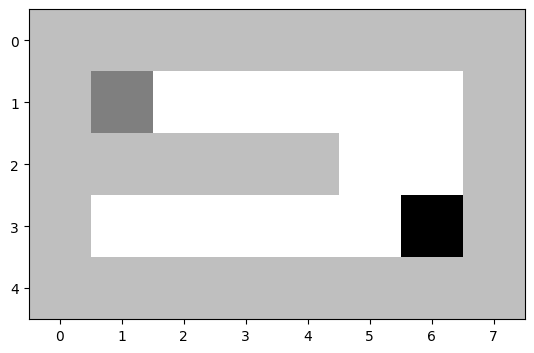

In [9]:
env.set_state(states[3])
print(env.get_observation(states[3]))
env.render()

In [15]:

observation = obs_dict[(1, 1, 1, 0, 0)]
action = 0
observation

28

In [16]:
env.get_state()

((np.int64(1), np.int64(1), 1), (2, 1))

In [23]:
env.T(states[1],1,states[11])

1.0

In [18]:
s = states[1]
s_ = states[11]

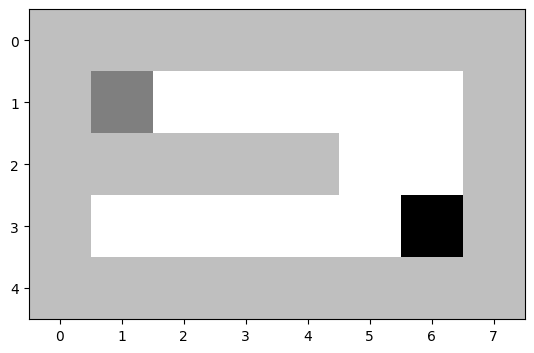

((1, 1, 0), (2, 1))

In [19]:
env.render(states[1])
states[1]

In [20]:
1. if np.all(env.step(1,states[1])[0] == states[11]) else 0

1.0

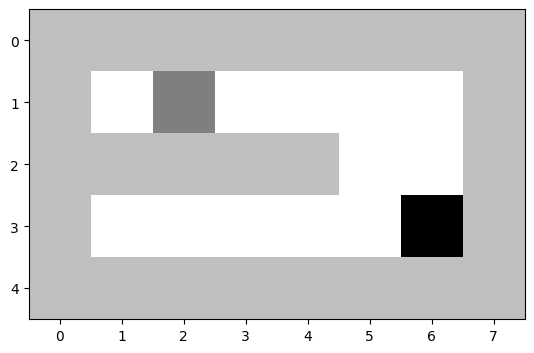

((np.int64(1), np.int64(2), 1), (2, 1))

In [22]:
env.step(1,execute=True)
env.render()
env.get_state()

In [24]:
state_dict[(np.int64(1), np.int64(2), 1), (2, 1)]

11

In [14]:
"""
Perform a Bayesian belief update in a POMDP with action-dependent transition and observation models.

Parameters:
    belief (torch.Tensor): Initial belief distribution over states, shape (num_states,)
    transition_matrix (torch.Tensor): Transition probabilities, shape (num_states, num_actions, num_states)
    observation_matrix (torch.Tensor): Observation probabilities, shape (num_states, num_actions, num_observations)
    action (int): The action taken (index of action)
    observation (int): The observation received (index of observation)

Returns:
    torch.Tensor: The updated belief over states, shape (num_states,)
"""
# Prediction Step: Compute predicted belief over next states
predicted_belief = torch.matmul(belief, T[:, action])

# Update Step: Multiply by observation likelihood
observation_likelihood = O[:, action, observation]
updated_belief = predicted_belief * observation_likelihood

# Normalize the updated belief to ensure it's a valid probability distribution
if updated_belief.sum() > 0:
    updated_belief /= updated_belief.sum() 



In [15]:
np.all(torch.eq(updated_belief, new_belief).numpy())

np.True_

In [16]:
updated_belief

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

Initial state:  ((1, 7, 3), (1, 1))


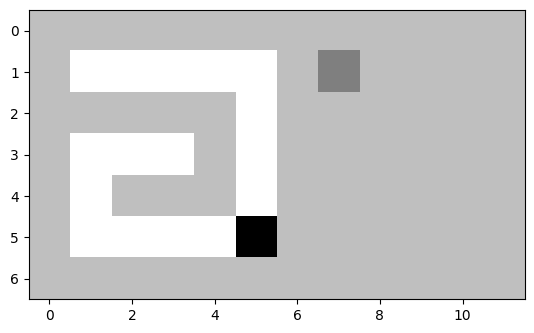

In [133]:
# the simulation starts with given belief and random state
b = torch.ones(len(states)) / len(states)
s = np.random.randint(len(states))


i = 54

print("Initial state: ", states[i])
env.render(states[i])


In [134]:
for i, ob in enumerate(obs):
    if np.all(ob == (1,1,1,1,1)):
        print("Observation: ", ob, i)
        break

Observation:  (1, 1, 1, 1, 1) 31


In [135]:
ob

(1, 1, 1, 1, 1)

In [137]:
O[54,0,31]

tensor(1)

In [112]:
b = env_wrapper.update_belief(b, 0, np.array([1,1,1,1,1]))


In [148]:
b = torch.ones(len(states)) / len(states)

[0 1 1 1 1]
observation:  [0 1 1 1 1] azzera il belief
actual state ((np.int64(1), np.int64(1), np.int64(3)), (2, 1))
0


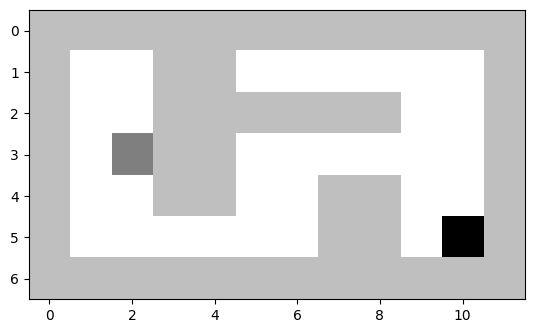

argmax and max Belief:  ((1, 1, 0), (1, 1)) tensor(0.)


In [156]:


action = np.random.choice([0,1,2,3])
next_obs, reward, done, info = env_wrapper.step(action, execute=True)
print(next_obs)
if np.any(next_obs==zeros_obs):
    print("observation: ", next_obs, "azzera il belief")
    b = torch.zeros_like(b)
next_state = info['actual_state']
print("actual state",next_state)
print(action)
env.render()

b = env_wrapper.update_belief(b, best_action, next_obs)

print("argmax and max Belief: ", states[torch.argmax(b)], torch.max(b))


